In [361]:
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [362]:
%load_ext autoreload
%autoreload 2
from minibatchperceptron import MinibatchPerceptron, MinibatchPerceptronOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Abstract

This blogpost explores the implementation of the perceptron as well as an exploration of its properties, capabilities, and limitations. This includes exploring how it performs on linearly separable data compared to data that is not linearly separable. Then the perceptron on data with more than 2 features is explored to prove that it still works as long as the data is linearly separable. Then the concept of a minibatch perceptron in which more than one data point is passed to the perceptron at a time. 

## Perceptron Source Code

Use this [link](https://github.com/jcummings25/github_jcummings25.github.io/blob/main/posts/Perceptron-Algorithm/perceptron.py) to access the perceptron source code.
Use this [link](https://github.com/jcummings25/github_jcummings25.github.io/blob/main/posts/Perceptron-Algorithm/minibatchperceptron.py) to access the minibatch perceptron source code.


```python
def grad(self, X, y):
    y_ = 2 * y - 1  # convert labels
    return (-1 * (self.score(X) * y_ < 0).float() * y_ * X).view(-1)
```

As seen in the above code, the grad function works by first converting the target variable classifications from {0,1} to {-1,1}. Inside the parentheses, this result is multiplied by the points corresponding score. The result of this comparison will be negative if the classification is incorrect and positive otherwise. After comparing this result to 0, we are left with a 0 if the classification is correct, and a 1 if it is incorrect. This means that no change is made to correct classifications. For incorrect classifications, they are then multiplied by the true classification and their feature's to create the change that is returned to the step function when called. The result is that the weight is adjusted by 0 if the classification is correct, and y_ multiplied by each feature if the classification is incorrect. .view(-1) ensures that the return is a 1d vector compatible with the implemented step algorithm.

Minibatch functions 

## Perceptron Basic Testing

#### Linearly Seperable Data

Let's start by creating and visualizing a set of 300 2D linearly classifiable data points, and visualize them on a 2D plane.

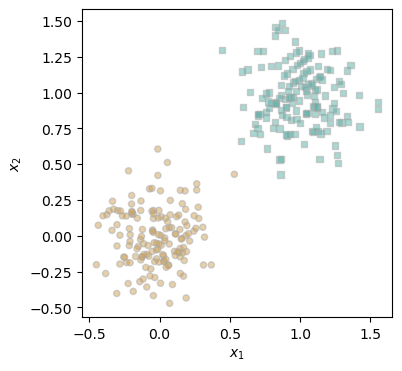

In [363]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(1234)

def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2):
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    return X, y


def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")


fig, ax = plt.subplots(1, 1, figsize = (4, 4))
X, y = perceptron_data()
plot_perceptron_data(X, y, ax)


#### Data Subset

Let's start with a subset of this data for exploratory purposes:

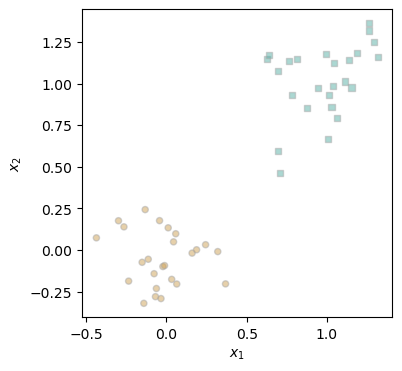

In [364]:
torch.manual_seed(1234)
X, y = perceptron_data(n_points = 50, noise = 0.2)
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_perceptron_data(X, y, ax)

While we have not done so yet, it is easy to see how a line could "linearly classify" (divide) these groups so that each group is on one side of that line. 

#### Minimal Training Loop

Let's do a minimal training loop on this data to show that our perceptron can correctly classify this data. 

In [365]:
import torch

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]
max_iter = 100000
iter = 0

while ((loss > 0) & (iter <= max_iter)): # dangerous -- only terminates if data is linearly separable
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    # pick a random data point
    ix = torch.randperm(X.size(0))[:1]
    x_i = X[ix, :]  
    y_i = y[ix]
 
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)



    
    iter = 1 + iter

    if iter == max_iter:
        print("Max iterations reached")
        
print(loss_vec)
print("Final loss: ", loss)
   
    

[tensor(0.5000), tensor(0.5000), tensor(0.)]
Final loss:  tensor(0.)


Our perceptron came up with a result without reaching our maximum number of itterations, meaning that it found a classification line with a loss equal to 0. Let's plot it to see what this looks like:

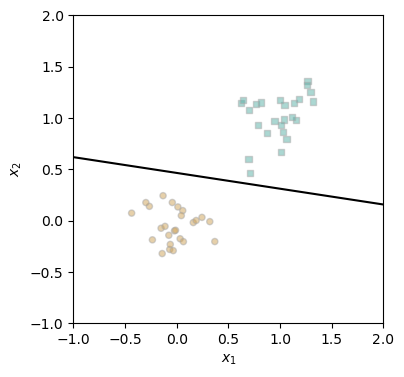

In [366]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)
draw_line(p.w, -1, 2, ax, color = "black")

Beautiful, our model has created a linear classification that splits our two groups into their respective categories. 

## Complete Run

Now let's do a complete run and demonstrate how our classification line adjusts with each update. Code from these [Class notes](https://www.philchodrow.prof/ml-notes/chapters/20-perceptron.html) "Complete Run" section was used to create this run and visualization.

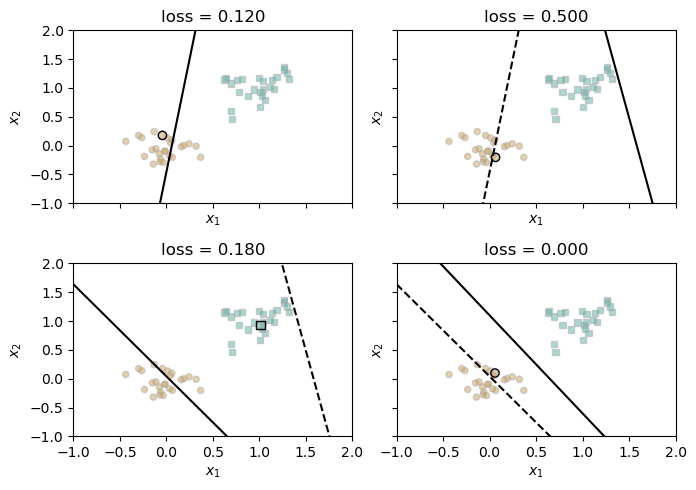

In [367]:
torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 2, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []

while loss > 0:
    ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)

    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 


    i = torch.randperm(X.size(0))[:1]
    x_i = X[i, :]  
    y_i = y[i]
    local_loss = p.loss(x_i, y_i).item()

    if local_loss > 0:
        opt.step(x_i, y_i)
    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if local_loss > 0:
        plot_perceptron_data(X, y, ax)
        draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[2*(y[i].item())-1]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        current_ax += 1
plt.tight_layout()

This chart shows each update of our weights (classification line). The previous line is shown dashed, the new line is shown solid, and the point the update is based upon is shown outlined in black. As demonstrated in this series of charts, our perceptron is picking a random point and updating the weights so that specific point is classified correctly. Because we only do this for points which are not correctly classified already we know that if the data is linearly separable our perceptron will converge. 

### Non-Linearly Seperable 2D Data

Let's generate some linearly non-separable data:

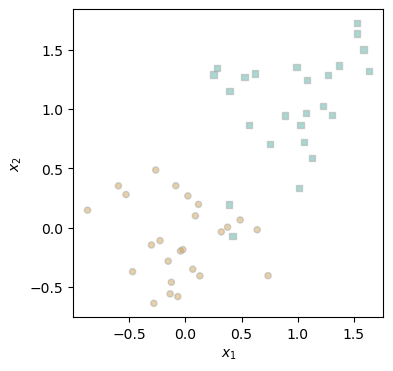

In [368]:
torch.manual_seed(1234)

def inseparable_data(n_points = 50, noise = 0.4, p_dims = 2):
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    return X, y


def plot_inseparable_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")


fig, ax = plt.subplots(1, 1, figsize = (4, 4))
X, y = inseparable_data()
plot_inseparable_data(X, y, ax)

As can be clearly seen just by looking, there is no line that can separate these two groups of data. The overlapping section means that our data is not linearly separable, and therefore our perceptron will never converge. 

With setting a maximum number of iterations, we can see more closely how these points cause problems for our perceptron. The following code sets the maximum number of itertions at 1000, and tracks the first 12 updates to demonstrate the mechanisms for why this never converges.

Once again, this code is borrowed from the [Class notes](https://www.philchodrow.prof/ml-notes/chapters/20-perceptron.html) "Complete Run" section with some minor alterations to set a maximum number of iterations and allow for more updates to be visualized.

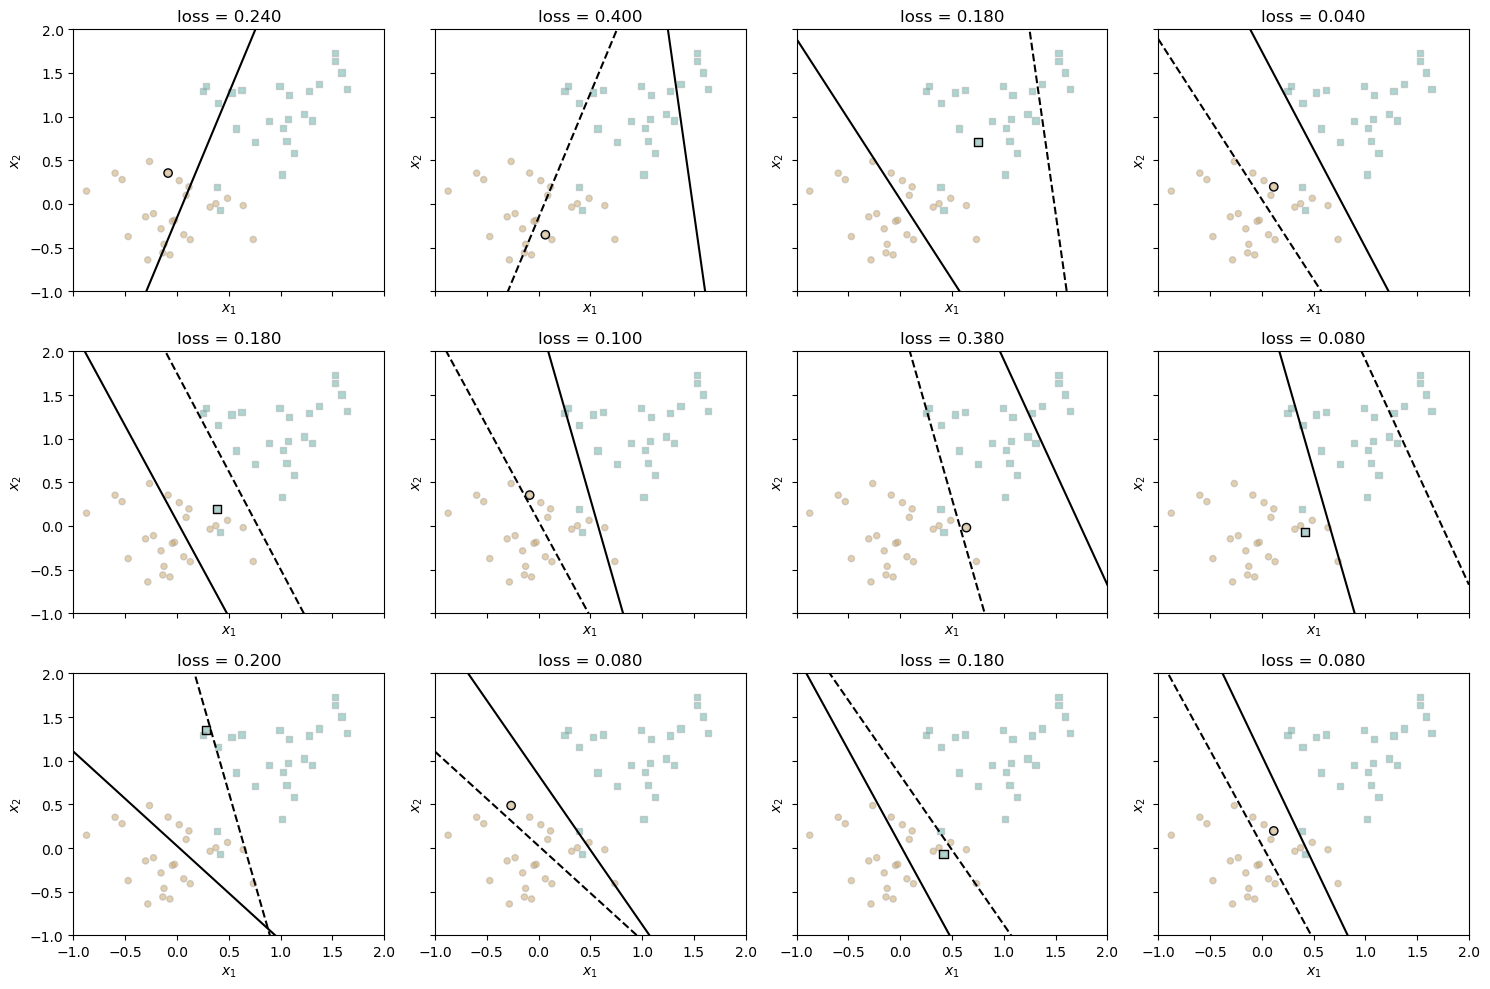

In [369]:
torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

# set up the figure
plt.rcParams["figure.figsize"] = (15, 10)
fig, axarr = plt.subplots(3, 4, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []

max_iter = 1000
iter = 0
count = 0

while (loss > 0) & (max_iter >= iter):
    iter += 1
    if count < 12:
        ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)

    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 

    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    local_loss = p.loss(x_i, y_i).item()

    if local_loss > 0:
        count +=1
        opt.step(x_i, y_i)
    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if (local_loss > 0) & (count <= 12):
        plot_perceptron_data(X, y, ax)
        draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[2*(y[i].item())-1]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        current_ax += 1
plt.tight_layout()

While only visualizing the first 12 updates, it is already clear from the above visualization that this data is never going to converge. The overlapping points in the middle, mean that any corrections will leave some combination in that small area incorrectly classified, and therefore our loss will never reach 0. Instead, by the 4th update, all subsequent updates take part in this back and forth of correcting so that a different, but incomplete, set of points are correctly classified. 

## Perceptron on 5D Features

It will now be shown that our perceptron can function on linearly separable data of more than two (5) dimensions:

In [370]:


torch.manual_seed(1234)

X, y = perceptron_data(n_points = 300, noise = 0.2, p_dims = 5)

print(X.shape)



torch.Size([300, 6])


With 5d data for 300 points, we can now do a minimal training loop and track the loss throughout in the same way done before:

In [371]:
import torch

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]
max_iter = 100000
iter = 0

while ((loss > 0.0) & (iter <= max_iter)): # dangerous -- only terminates if data is linearly separable
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i], :]  # Transpose x_i to make its shape compatible for multiplication
    y_i = y[i]
 
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)



    
    iter = 1 + iter

    if iter == max_iter:
        print("Max iterations reached")
        
   
    

Since our perceptron converged, let's take a look at how the loss changed throughout our training loop:

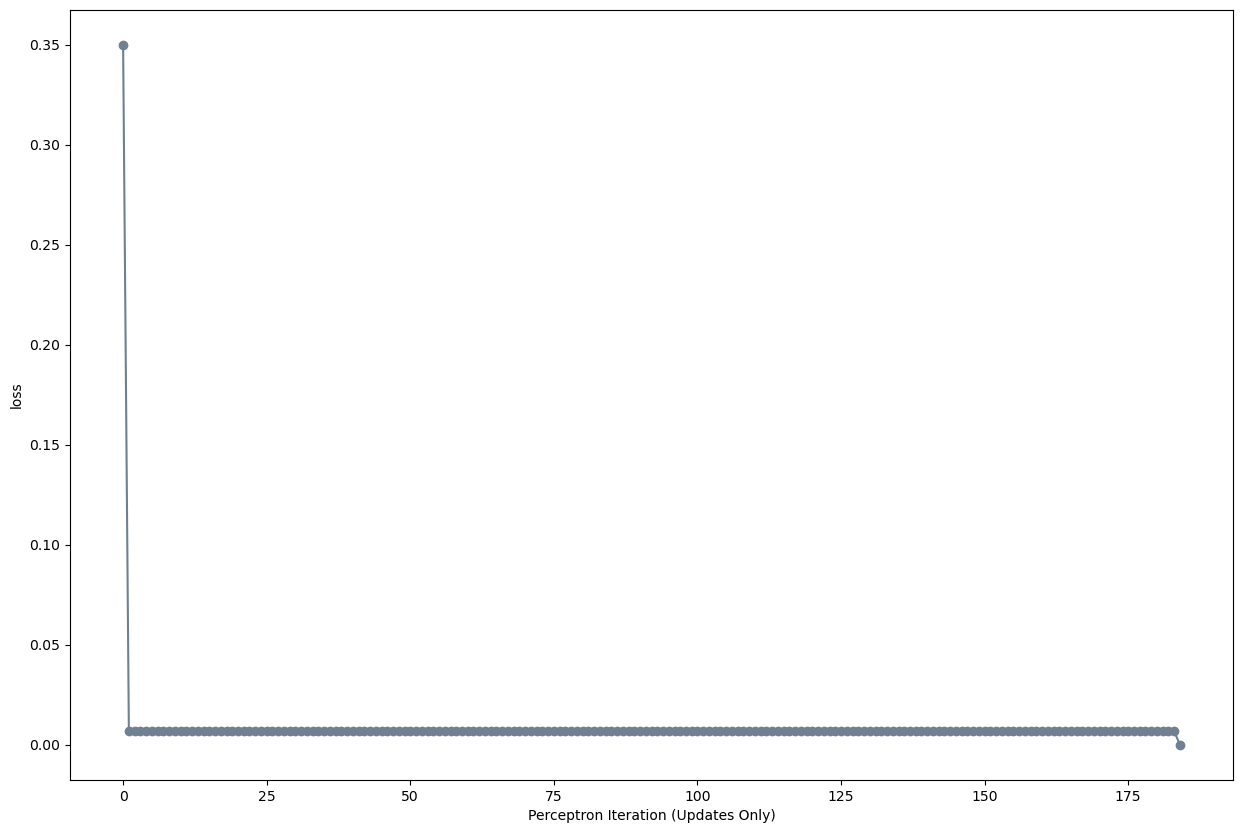

In [372]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

It is interesting to see that with a single update, our loss was reduced to .0067 with no more updates for more than 150 iterations when a single further update reduced the loss to 0.

I know that the data is linearly separable, because the loss ends at 0 and our perceptron converged. There is no way to know that your data is not linearly separable with higher dimensions where you cannot simply look at a visualization and know. 

## Mini Batch Perceptron

In this section a Minibatch perceptron will be implemented which computes an update using k points at once, rather than a single point.

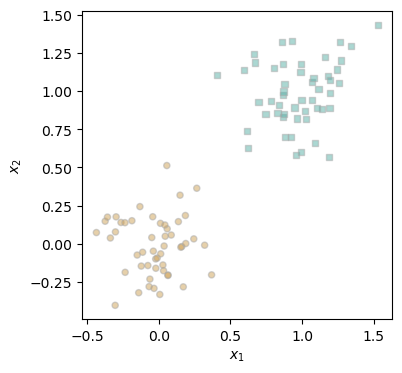

In [373]:
torch.manual_seed(1234)
X, y = perceptron_data(n_points = 100, noise = 0.2, p_dims = 2)
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_perceptron_data(X, y, ax)

We are once again starting with a subset of the same set of linearly separable points.

#### Minimal Training Loop

Now we will run our perceptron on a minimal training loop where we will pass in K random indices to the perceptron: 

In [374]:
import torch

# instantiate a model and an optimizer
p = MinibatchPerceptron() 
opt = MinibatchPerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]
max_iter = 100000
iter = 0

while ((loss > 0.0) & (iter <= max_iter)): # dangerous -- only terminates if data is linearly separable
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    # pick a random data point
    k = 1
    ix = torch.randperm(X.size(0))[:k]
    x_i = X[ix, :]  
    y_i = y[ix]
 
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)    
    iter = 1 + iter

    if iter == max_iter:
        print("Max iterations reached")
        

print("Final loss: ", loss)
print("loss vector: ", loss_vec)

Final loss:  tensor(0.)
loss vector:  [tensor(0.5000), tensor(0.2700), tensor(0.4500), tensor(0.4500), tensor(0.4500), tensor(0.0100), tensor(0.0100), tensor(0.0100), tensor(0.0100), tensor(0.0100), tensor(0.0100), tensor(0.0100), tensor(0.0100), tensor(0.0100), tensor(0.0100), tensor(0.0100), tensor(0.0100), tensor(0.0100), tensor(0.0100), tensor(0.2700), tensor(0.0400), tensor(0.0400), tensor(0.0400), tensor(0.0400), tensor(0.)]


In [375]:
torch.manual_seed(1234567)

def min_batch_full_loop(X, y, k, x_plots, y_plots):
    # initialize a perceptron 
    p = MinibatchPerceptron()
    opt = MinibatchPerceptronOptimizer(p)
    p.loss(X, y)

    # set up the figure
    plt.rcParams["figure.figsize"] = (7, 5)
    fig, axarr = plt.subplots(x_plots, y_plots, sharex = True, sharey = True)
    markers = ["o", ","]
    marker_map = {-1 : 0, 1 : 1}

    # initialize for main loop
    current_ax = 0
    loss = 1
    loss_vec = []

    while loss > 0:
        ax = axarr.ravel()[current_ax]

        # save the old value of w for plotting later
        old_w = torch.clone(p.w)

        # make an optimization step -- this is where the update actually happens
        # now p.w is the new value 

        ix = torch.randperm(X.size(0))[:k]
        x_i = X[ix, :]  
        y_i = y[ix]
        local_loss = p.loss(x_i, y_i).item()

        if local_loss > 0:
            opt.step(x_i, y_i)
        # if a change was made, plot the old and new decision boundaries
        # also add the new loss to loss_vec for plotting below
        if local_loss > 0:
            plot_perceptron_data(X, y, ax)
            draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
            loss = p.loss(X, y).item()
            loss_vec.append(loss)
            draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
            #ax.scatter(ix[[]])
            for i in range(k): # cycle through the k points and outline them in black
                ax.scatter(X[ix[i]][0], X[ix[i]][1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[2*(y[i].item())-1]])
            ax.set_title(f"loss = {loss:.3f}")
            ax.set(xlim = (-1, 2), ylim = (-1, 2))
            current_ax += 1
    plt.tight_layout()



#### K = 1 minibatch

Let's see what happens when we perform a minibatch with a k of size = 1:

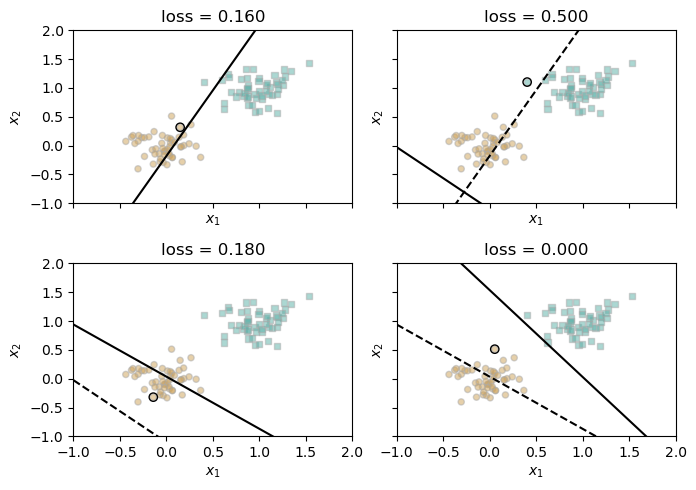

In [376]:
min_batch_full_loop(X, y, 1, 2,2)

As show, the minibatch acts in exactly the same way as a normal perceptron, which makes sense because it is taking an average of a single point's correction, which is the same as just basing the correction on that single point. 

#### Minibatch with k=10

Now Let's try a real minibatch with a k = 10:

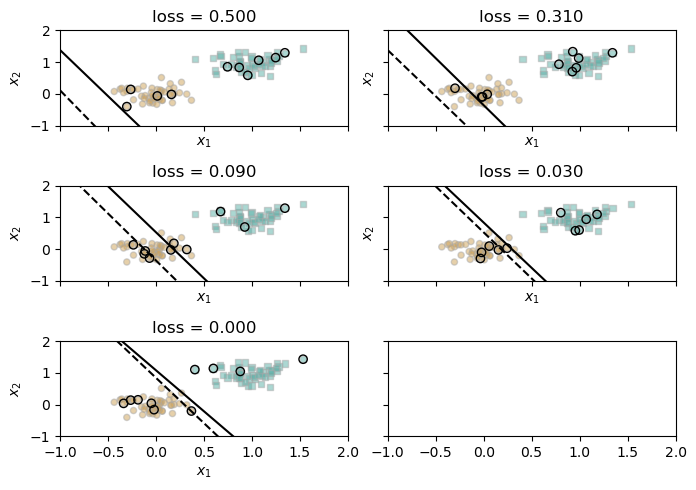

In [377]:
min_batch_full_loop(X, y, 10, 3, 2)

As seen in the above visualization, the correction is done based on the classification of all of the selected points, which includes some who will be correctly classified resulting in a lower mean gradient calculation. That is why the changes are often much smaller than the corrections seen when k = 1. 

#### Minibatch when k = n (n=100)

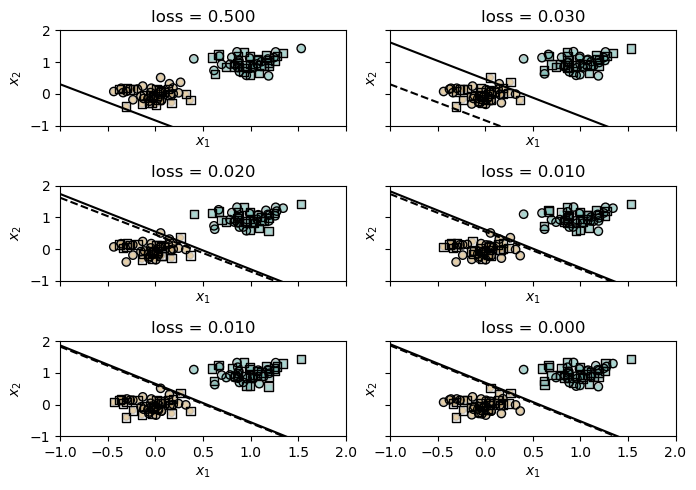

In [378]:
min_batch_full_loop(X, y, 100, 3, 2)

This point is driven home even more clearly by the demonstration when k = n (100). While the first update is quite large to overcome the fact that half the points are wrongly classified , all subsequent updates are very small due to the fact that so few points of the ones selected are incorrectly classified. 

## Complexity Analysis

What is the runtime complexity of a single iteration of the perceptron algorithm? Does the runtime complexity of a single iteration depend on the number of data points n? What about the number of features p? 

The runtime of the perceptron algorithm is O(p). This is driven by the dot product calculation of the scoring function: X@self.w. As such, the number of features p has a direct impact on the complexity, as the complexity of a dot product is O(n), and in this case the length of the vectors is based on the number of features p. The total number of data points has no impact on this.

If you implemented minibatch perceptron, what is the runtime complexity of a single iteration of the minibatch perceptron algorithm?


For the minibatch, where k is the size of the batch, a single iteration is O(k*p). This is because we must calculate the score for every one of the points in the batch. 

## Discussion

This blog post has explored the perceptron and minibatch perceptron algorithms. The perceptron is an effective algorithm for optimizing weights for linearly separable data, however it is ineffective when data is not linearly separable. It functions by randomly selecting a datapoint, and if it is incorrectly classified by current weights, the weights are update based on the gradient of the error. This process continues until all data points are correctly classified—only possible if the data is in fact linearly separable. This all applies for data that has 2 or more features. However, the time complexity of performing each iteration of the algorithm is increased by the number of features. The minibatch perceptron functions in much the same way as the perceptron, except instead of calculating the weight adjustment for a single datapoint, it takes the average of several. This is interesting as it allows for some adjustment minimizing for points which are classified correctly. Additionally, each additional point in a batch increases the time complexity of an iteration of the batch.